<a href="https://colab.research.google.com/github/mmadyda/OpenCV/blob/master/Klasyfikator_binarny_dron_samolot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import bibliotek

In [0]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)


##załadowanie danych

In [0]:
 !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
 !unzip -q flying-vehicles.zip

--2020-05-06 16:28:50--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.176, 2607:f8b0:4007:808::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  82.4MB/s    in 19s     

2020-05-06 16:29:09 (79.3 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [0]:
!rm -rf ./images

In [0]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone','fighter-jet','helicopter','missile','passenger-plane','rocket']
for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [0]:
data_dir='./images'
if not os.path.exists(data_dir):
  os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir,'test')

train_drone_dir = os.path.join(train_dir,'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir,valid_drone_dir, valid_passenger_dir,test_drone_dir,test_passenger_dir]

for dir in dirs:
  if not os.path.exists(dir):
    os.mkdir(dir)

    

In [0]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg','png','jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg','png','jpeg']]

In [0]:
size = min(len(drone_fnames),len(passenger_fnames))

train_size = int(np.floor(0.7*size))
valid_size = int(np.floor(0.2*size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [0]:
for i, fname in enumerate(drone_fnames):
  if i <= train_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(train_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < i <= valid_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(valid_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(test_drone_dir, fname)
    shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
  if i <= train_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(train_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < i <= valid_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(valid_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(test_passenger_dir, fname)
    shutil.copyfile(src, dst)




In [0]:
print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


##Eksploracja danych

(-0.5, 1049.5, 699.5, -0.5)

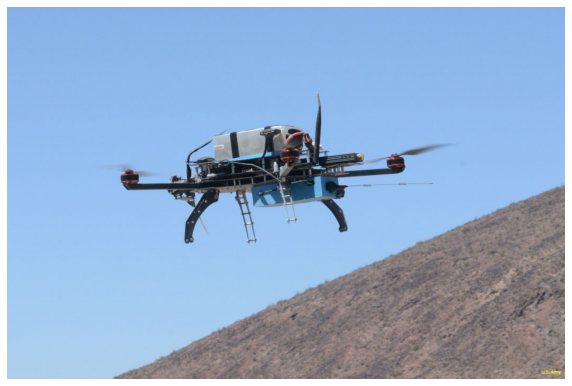

In [0]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego
idx = 220 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 2775.5, 1855.5, -0.5)

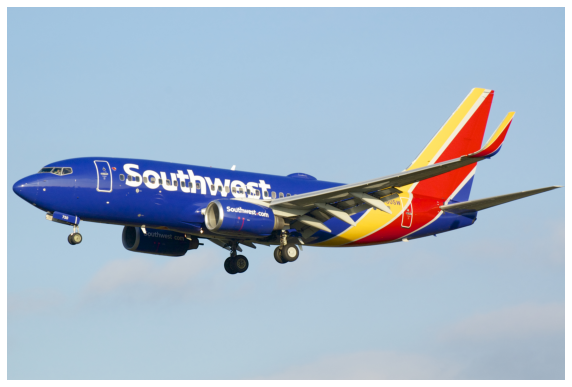

In [0]:
#@title Wybierz indeks przykładowego zdjęcia samolotu ze zbioru treningowego
idx = 128 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

##Argumentacja danych

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1.0/255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
print('train generator')
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode = 'binary')
print('valid generator')
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='binary')

train generator
Found 1838 images belonging to 2 classes.
valid generator
Found 524 images belonging to 2 classes.


In [0]:
def display_augumented_images(directory, idx):
  fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
  img_path = fnames[idx]
  img = image.load_img(img_path, target_size=(150,150))

  x = image.img_to_array(img)
  x = x.reshape((1,)+x.shape)

  i=1

  plt.figure(figsize=(20,14))
  for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
      break


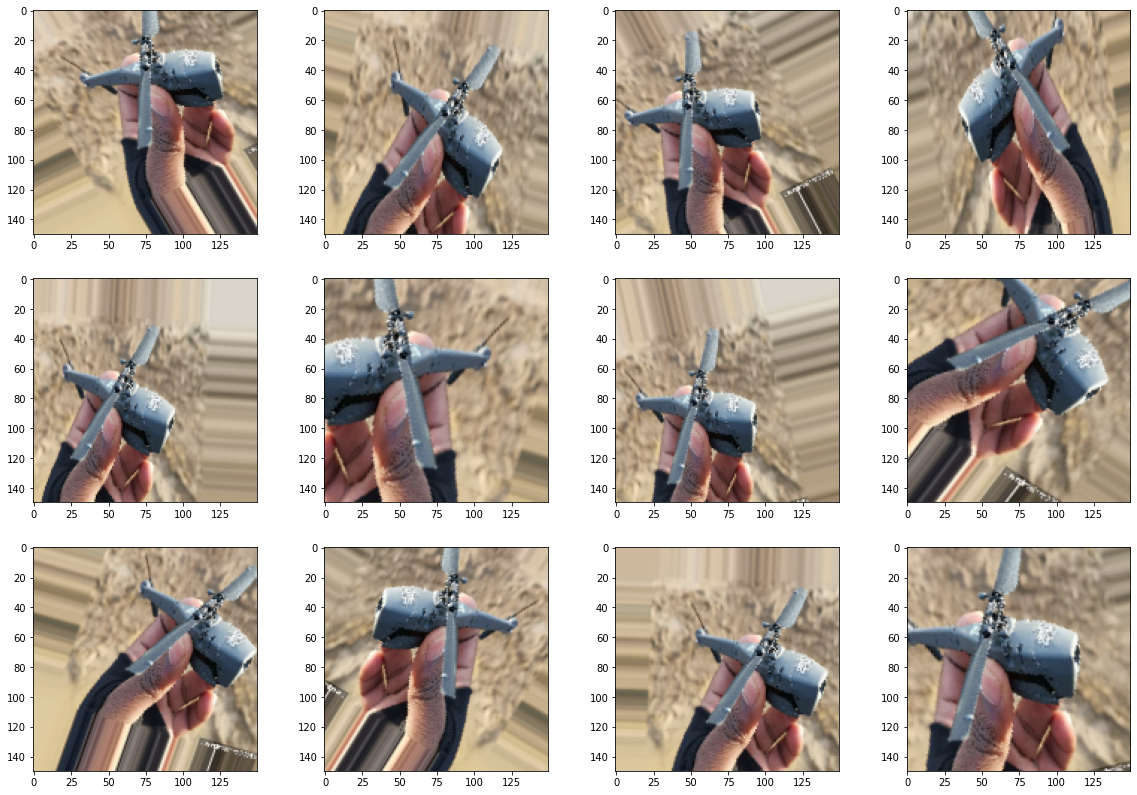

In [0]:
#@title Zbiór treningowy dron:
idx = 86 #@param {type:'slider', min:0, max:919}
display_augumented_images(train_drone_dir,idx)

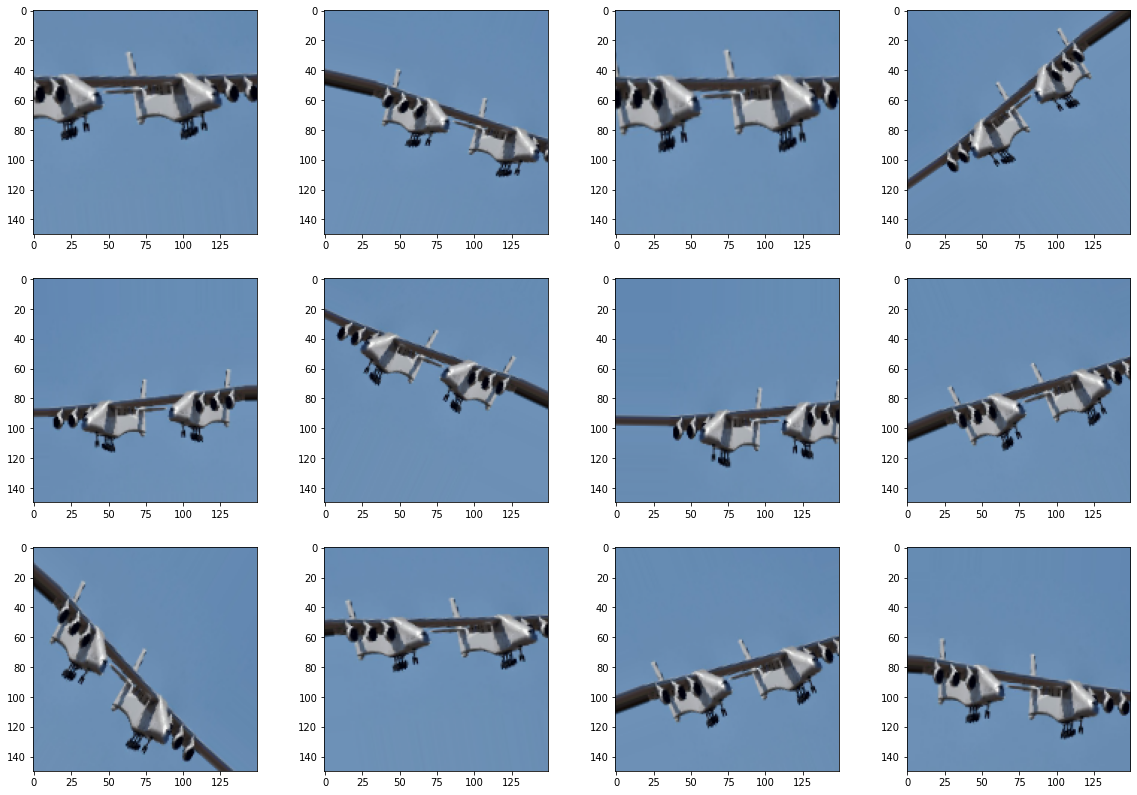

In [0]:
#@title Zbiór treningowy samolot:
idx = 466 #@param {type:'slider', min:0, max:919}
display_augumented_images(train_passenger_dir,idx)

##Budowa modelu

In [0]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation = 'relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation = 'relu'))
model.add(layers.Dense(units=1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [0]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [0]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = 30,
                              validation_data=valid_generator,
                              validation_steps = validation_steps,
                              callbacks=[tensorboard])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
28/28 [==============================] - 25s 884ms/step - loss: 0.7065 - accuracy: 0.5011 - val_loss: 0.6896 - val_accuracy: 0.5312
Epoch 2/30
28/28 [==============================] - 22s 797ms/step - loss: 0.6902 - accuracy: 0.5201 - val_loss: 0.6805 - val_accuracy: 0.6059
Epoch 3/30
28/28 [==============================] - 22s 800ms/step - loss: 0.6776 - accuracy: 0.5786 - val_loss: 0.6854 - val_accuracy: 0.5352
Epoch 4/30
28/28 [==============================] - 24s 856ms/step - loss: 0.6861 - accuracy: 0.5547 - val_loss: 0.6729 - val_accuracy: 0.5508
Epoch 5/30
28/28 [==============================] - 24s 848ms/step - loss: 0.6752 - accuracy: 0.5740 - val_loss: 0.6682 - val_accuracy: 0.6094
Epoch 6/30
28/28 [==============================] - 22s 795ms/step - loss: 0.6572 - accuracy: 0.6217 - val_loss: 0.6973 - val_accuracy: 0.5551
Epoch 7/30
28/28 [==============================] - 24s 860ms/step

In [0]:
%load_ext tensorboard

In [0]:
!tensorboard dev upload --logdir logs

2020-05-06 16:50:34.576612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'], y = hist['accuracy'], name = 'accuracy', mode = 'markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'], y = hist['val_accuracy'], name = 'val_accuracy', mode = 'markers+lines'))
  fig.update_layout(width=1000,height = 500, title = 'Accurracy vs. Val Accuracy', xaxis_title = 'Epoki', yaxis_title = 'Accuracy')
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'],name='loss',mode = 'markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name = 'val_loss', mode = 'markers+lines'))
  fig.update_layout(width=1000, height = 500, title='Loss vs. Val Loss',xaxis_title = 'Epoki', yaxis_title='Loss')
  fig.show()

plot_history(history)


##Transfer learning - model VGG16

In [0]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation = 'relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
print(f'liczba warstw trenowanych przed zamrożeniem: {len(model.trainable_weights)}')
conv_base.trainable = False
print(f'liczba warstw trenowanych po zamrożeniu {len(model.trainable_weights)}')

liczba warstw trenowanych przed zamrożeniem: 30
liczba warstw trenowanych po zamrożeniu 4


In [0]:
model.compile(optimizer = optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(generator = valid_generator,
                              steps_per_epoch = train_size // batch_size,
                              epochs = 50,
                              validation_data = valid_generator,
                              validation_steps = valid_size // batch_size,
                              callbacks = [tensorboard])

Epoch 1/50
28/28 [==============================] - 21s 762ms/step - loss: 0.5397 - accuracy: 0.7161 - val_loss: 0.4396 - val_accuracy: 0.7881
Epoch 2/50
28/28 [==============================] - 22s 788ms/step - loss: 0.3586 - accuracy: 0.8447 - val_loss: 0.2535 - val_accuracy: 0.9195
Epoch 3/50
28/28 [==============================] - 23s 807ms/step - loss: 0.2663 - accuracy: 0.9132 - val_loss: 0.1891 - val_accuracy: 0.9661
Epoch 4/50
28/28 [==============================] - 21s 761ms/step - loss: 0.2019 - accuracy: 0.9381 - val_loss: 0.1417 - val_accuracy: 0.9727
Epoch 5/50
28/28 [==============================] - 21s 756ms/step - loss: 0.1571 - accuracy: 0.9685 - val_loss: 0.1469 - val_accuracy: 0.9766
Epoch 6/50
28/28 [==============================] - 22s 772ms/step - loss: 0.1294 - accuracy: 0.9673 - val_loss: 0.1031 - val_accuracy: 0.9922
Epoch 7/50
28/28 [==============================] - 22s 791ms/step - loss: 0.0929 - accuracy: 0.9863 - val_loss: 0.0834 - val_accuracy: 0.9831

In [0]:
import plotly.graph_objects as go
plot_history(history)

##Transfer learning - model VGG16 odmrożenie kilku ostatnich warstw

In [0]:
conv_base = VGG16(weights = 'imagenet',include_top=False,input_shape=(150,150,3))
conv_base.trainable = True
def print_layers(model):
  for layer in model.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')
  
print_layers(conv_base)

layer_name: input_5       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [0]:
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  layer.trainable = set_trainable

print_layers(conv_base)

layer_name: input_5       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [0]:
model = Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation = 'relu'))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch=train_size // batch_size,
                              epochs = 30,
                              validation_data = valid_generator,
                              validation_steps = valid_size // batch_size,
                              callbacks = [tensorboard])

Epoch 1/30
28/28 [==============================] - 25s 877ms/step - loss: 0.7106 - accuracy: 0.6094 - val_loss: 0.4430 - val_accuracy: 0.7966
Epoch 2/30
28/28 [==============================] - 25s 885ms/step - loss: 0.5355 - accuracy: 0.7153 - val_loss: 0.4681 - val_accuracy: 0.7695
Epoch 3/30
28/28 [==============================] - 26s 917ms/step - loss: 0.5357 - accuracy: 0.7422 - val_loss: 0.4687 - val_accuracy: 0.7415
Epoch 4/30
28/28 [==============================] - 24s 867ms/step - loss: 0.4479 - accuracy: 0.7790 - val_loss: 0.3522 - val_accuracy: 0.8320
Epoch 5/30
28/28 [==============================] - 26s 914ms/step - loss: 0.4798 - accuracy: 0.7701 - val_loss: 0.3787 - val_accuracy: 0.7881
Epoch 6/30
28/28 [==============================] - 25s 910ms/step - loss: 0.4347 - accuracy: 0.8030 - val_loss: 0.3546 - val_accuracy: 0.8516
Epoch 7/30
28/28 [==============================] - 25s 880ms/step - loss: 0.4339 - accuracy: 0.8080 - val_loss: 0.3735 - val_accuracy: 0.8475

In [0]:
plot_history(history)

##Ocena modelu na zbiorze testowym

In [0]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size = 1,
    class_mode = 'binary',
    shuffle = False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 262 images belonging to 2 classes.


array([0.01214 , 0.278247, 0.000051, 0.      , 0.      , 0.076152,
       0.00045 , 0.59354 , 0.      , 0.000574, 0.00053 , 0.006909,
       0.016864, 0.000603, 0.664069, 0.86229 , 0.0402  , 0.      ,
       0.000001, 0.000318, 0.000001, 0.000001, 0.113963, 0.002635,
       0.657611, 0.      , 0.000117, 0.      , 0.999754, 0.903245,
       0.046407, 0.108477, 0.      , 0.000025, 0.      , 0.000002,
       0.      , 0.      , 0.000032, 0.011428, 0.837674, 0.629835,
       0.774977, 0.132606, 0.110554, 0.005641, 0.000004, 0.011551,
       0.000017, 0.968166, 0.000024, 0.022596, 0.99901 , 0.031132,
       0.986034, 0.999961, 0.078973, 0.      , 0.      , 0.000017,
       0.922103, 0.272352, 0.000032, 0.000013, 0.859272, 0.      ,
       0.055369, 0.126437, 0.08421 , 0.079222, 0.60076 , 0.      ,
       0.545306, 0.      , 0.978179, 0.056662, 0.400528, 0.002641,
       0.12896 , 0.      , 0.755002, 0.49467 , 0.      , 0.012662,
       0.      , 0.834194, 0.370557, 0.164326, 0.0119  , 0.006

In [0]:
predictions = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,1.214025e-02,0
1,2.782472e-01,0
2,5.105948e-05,0
3,3.887181e-09,0
4,1.989127e-27,0
...,...,...
257,9.854086e-01,1
258,5.895371e-01,1
259,9.377670e-01,1
260,1.000000e+00,1


In [0]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [0]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [0]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[102,  29],
       [ 16, 115]])

In [0]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       131
           1       0.80      0.88      0.84       131

    accuracy                           0.83       262
   macro avg       0.83      0.83      0.83       262
weighted avg       0.83      0.83      0.83       262



##Wyświetlanie błędów predykcji

In [0]:
errors = pd.DataFrame({'y_true':y_true,'y_pred':y_pred},index = test_generator.filenames)
errors

,y_true,y_pred
drone/00000015.jpeg,0,0
drone/00000026.png,0,0
drone/00000037.jpg,0,0
drone/00000046.jpg,0,0
drone/00000067.jpg,0,0
...,...,...
passenger/00001441.jpg,1,1
passenger/00001445.jpg,1,1
passenger/00001451.jpg,1,1
passenger/00001468.jpg,1,1


In [0]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000015.jpeg,0,0,0
drone/00000026.png,0,0,0
drone/00000037.jpg,0,0,0
drone/00000046.jpg,0,0,0
drone/00000067.jpg,0,0,0
...,...,...,...
passenger/00001441.jpg,1,1,0
passenger/00001445.jpg,1,1,0
passenger/00001451.jpg,1,1,0
passenger/00001468.jpg,1,1,0


In [0]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000086.jpg', 'drone/00000193.jpeg', 'drone/00000194.jpg',
       'drone/00000312.jpg', 'drone/00000351.jpg', 'drone/00000379.png',
       'drone/00000525.png', 'drone/00000530.jpg', 'drone/00000532.JPG',
       'drone/00000593.jpg', 'drone/00000636.jpeg', 'drone/00000667.jpg',
       'drone/00000678.jpg', 'drone/00000763.jpg', 'drone/00000820.jpg',
       'drone/00000882.jpeg', 'drone/00000891.JPG', 'drone/00000904.jpg',
       'drone/00000952.jpg', 'drone/00000995.jpg', 'drone/00001042.jpg',
       'drone/00001112.jpg', 'drone/00001119.jpg', 'drone/00001199.jpg',
       'drone/00001267.jpg', 'drone/00001284.jpg', 'drone/00001311.jpg',
       'drone/00001325.jpg', 'drone/00001344.jpg', 'passenger/00000291.png',
       'passenger/00000310.jpg', 'passenger/00000368.jpg',
       'passenger/00000429.png', 'passenger/00000493.jpg',
       'passenger/00000552.png', 'passenger/00000628.png',
       'passenger/00000729.jpg', 'passenger/00000763.jpg',
       'passenger/00000827.

(-0.5, 1999.5, 1100.5, -0.5)

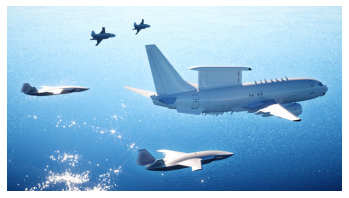

In [0]:
img_path = os.path.join(test_drone_dir, '00000952.jpg')
img = image.load_img(img_path)
plt.imshow(img)
plt.axis(False)

(-0.5, 749.5, 490.5, -0.5)

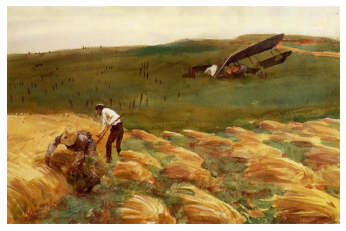

In [0]:
img_path = os.path.join(test_passenger_dir, '00000729.jpg')
img = image.load_img(img_path)
plt.imshow(img)
plt.axis(False)